<a href="https://colab.research.google.com/github/lblogan14/Python_Deep_Learning/blob/master/ch6_gan_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intuition and Justification of Generative Models
The neural networks introduced so far are used as **discriminative models**, which means that given input data, a discriminative model will map it to a certain label (a classification). A discriminative model gives the probability of $y$ (class), given $x$ (input), $P(Y|X=x)$.

A **generative model** learns the distribution of the classes, which is the opposite of what the discriminative model does. Instead of predicting the class probability $y$, given certain input features, it tries to predict the probability of the input features, given a class $y$, $Y(X|Y=y)$.

#Variational Autoencoders
An autoencoder is a feed-forward neural network that tries to reproduce its input. The target value (label) of an autoencoder is equal to the input data, $y^i=x^i$, where $i$ is the sample index. It tries to learn an identity function, $h_{w,w'}(x)=x$. The autoencoder is an unsupervised algorithm and represent as below:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch6/autoencoder.PNG?raw=true)

An autoencoder consists of an input, hidden (or bottleneck), and output layers. Although it's a single network, it can be treated as a virtual composition of two components:
* **Encoder**: Maps the input data to the network's internal representation.
* **Decoder**: Tries to reconstruct the input from the network's internal data representation.

The autoencoder is trained by minimizing a loss function called **reconstruction error** $\mathcal{L}=(x,x')$, which measures the distance between the original input and its reconstruction. The distance measures can be MSE or binary cross-entropy.

The autoencoder gains significance due to its internal data representation, known as representation in the **latent space**. The latent space contains hidden data features, which are not directly observed, but are inferred by the algorithm instead. The key is that the bottleneck layer has fewer neurons than the input/output ones.
* Because the network tries to reconstruct its input from a smaller feature space, it learns a compact representation of the data.
* By using fewer neurons, the network is foced to learn only the most important features of the data.

The encoder maps each input sample to the latent space and each attribute of the latent representation has a discrete value. That means that an input sample can have only one latent representation. Therefore, the decoder can reconstruct the input in only one possible way.

A VAE can describe the latent representation in probabilistic terms. Instead of discrete values, a probability distribution is obtained for each latent attribute, making the latent space continuous. For example, to encode an image of a vehicle and the latent representation is asked to have $n$ attributes ($n$ neurons in the bottleneck layer). Each attribute represents one vehicle property, such as length, height, and width, as shown below

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch6/vae_example.PNG?raw=true)

Assume the average vehicle length is 4 meters. Instead of the fixed value, the VAE can decode this property as a normal distribution with a mean of 4. Then the decoder can choose to sample a latent variable from the range of its distribution. It may reconstruct a longer and lower vehicle, compared to the input. In this way, the VAE can generate an unlimited number of modified versions of the input.

Formalism:
* Denote the encoder with $q_{\phi}(z|x)$, where $\phi$ are the weights and biases of the network, $x$ is the input, and $z$ is the latent space representation. The encoder output is a distribution (for example, Gaussian) over the possible values of $z$, which could have generated $x$.
* Denote the decoder with $p_{\theta}(x|z)$, where $\theta$ are the decoder weights and biases. First, $z$ is sampled stochastically (randomly) from the distribution. Then, it's sent through the decoder, whose output is a distribution over the possible corresponding values of $x$.
* The VAE uses a special type of loss function with two terms:
$$L(\theta,\phi;x)=-D_{KL}(q_{\phi}(z|x)|p_{\theta}(z)) + E_{q_{\phi}(z|x)}[\log(p_{\theta}(x|z))]$$
The first is the **Kullback-Leibler divergence** between the probability distribution $q_{\phi}(z|x)$ and the expected probability distribution, $p(z)$. It measures how much information is lost, when $q_{\phi}(z|x)$ is used to represent $p(z)$ (how close the two distributions are). It encourages the autoencoder to explore different reconstructions. \\
The second is the reconstruction loss, which measures the difference between the original input and its reconstruction. The more they differ, the more it increases. Therefore, it encourages the autoencoder to better reconstruct the data.

To implement this, the bottleneck layer will not directly output the latent state variables. Instead, it will output two vectors, which describe the **mean** and **variance** of the distribution of each latent variable:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch6/vae_sampling.PNG?raw=true)

Once the mean and variance distributions are available, a state $z$ can be sampled from the latent variable distributions and passed through the decoder for reconstruction. However, the backpropagation does not work over  random processes such as here. Hence, this has to be solved with **reparameterization trick**. \\
First, sample a random vector $\epsilon$ with the same dimensions as $z$ from a Gaussian distribution as shown in the figure above. Then shift it by the latent distribution's mean $\mu$ and scale it by the latent distribution's variance $\sigma$:
$$z=\mu + \sigma \odot \epsilon$$
In this way, the mean and variance can be optimized (shown in red arrows in the figure above) and the random generator can be omitted from the backward pass. At the same time, the sampled data will have the properties of the original distribution.

##VAE with MNIST
A VAE can generate new digits for the MNIST dataset.

Keras:

In [0]:
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import numpy as np

from keras import backend as K
from keras.datasets import mnist
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy
from keras.models import Model
%matplotlib inline

Using TensorFlow backend.


Instantiate the MNIST dataset:

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
image_size = x_train.shape[1] * x_train.shape[2]
x_train = np.reshape(x_train, [-1, image_size])
x_test = np.reshape(x_test, [-1, image_size])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Implement the `build_vae` function
* separate the access to the encoder,decoder, and the full network.
* The bottleneck layer will have only 2 neurons (2 latent variables) so as to display the latent distribution as a 2D plot.
* The encoder/decoder will contain a single intermediate (hidden) fully-connected layer with 512 neurons. This is not a convolutional network.
* Use cross-entropy reconstruction loss and KL divergence

In [0]:
def build_vae(intermediate_dim=512, latent_dim=2):
  '''
  Build VAE
  :param intermediate_dim: size of hidden layers of the encoder/decoder
  :param latent_dim: latent space size
  :returns tuple: the encoder, the decoder, and the full VAE 
  '''

  # Encoder first
  inputs = Input(shape=(image_size,), name='encoder_input')
  x = Dense(intermediate_dim, activation='relu')(inputs)

  # Latent mean and variance
  z_mean = Dense(latent_dim, name='z_mean')(x)
  z_log_var = Dense(latent_dim, name='z_log_var')(x)

  # Reparametrization trick for random sampling
  # Note the use of the Lambda layer
  # At runtime, it will call the sampling function
  z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

  # Full encoder model
  encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
  encoder.summary()

  # Decoder
  latent_inputs = Input(shape=(latent_dim,),
                        name='z_sampling')
  x = Dense(intermediate_dim, activation='relu')(latent_inputs)
  outputs = Dense(image_size, activation='sigmoid')(x)

  # Full decoder model
  decoder = Model(latent_inputs, outputs, name='decoder')
  decoder.summary()

  # VAE model
  outputs = decoder(encoder(inputs)[2])
  vae = Model(inputs, outputs, name='vae')

  # Loss function
  # start with the reconstruction loss
  reconstruction_loss = binary_crossentropy(inputs, outputs) * image_size

  # next is the KL divergence
  kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5

  # combine them in a total loss
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  vae.add_loss(vae_loss)

  return encoder, decoder, vae

The `sampling` function implements the random sampling of latent vectors `z`, using the reparameterization trick

In [0]:
def sampling(args: tuple):
  '''
  Reparameterization trick by sampling z from unit Gaussian
  :param args: (tensor, tensor) mean and log of variance of q(z|x)
  :returns tensor: sampled latent vector z
  '''

  # Unpack the input tuple
  z_mean, z_log_var = args

  # Mini-batch size
  mb_size = K.shape(z_mean)[0]

  # Latent space size
  dim = K.int_shape(z_mean)[1]

  # Random normal vector with mean=0 and std=1.0
  epsilon = K.random_normal(shape=(mb_size, dim))

  return z_mean + K.exp(0.5 * z_log_var) * epsilon

The `plot_latent_distribution` function collects the latent representations of all images in the test set and displays them over a 2D plot. The two latent variables `z1` and `z2` are the axes of 2D plot.

In [0]:
def plot_latent_distribution(encoder, x_test, y_test, batch_size=128):
  '''
  Display a 2D plot of the digit classes in the latent space.
  Interested only in z, so only need the encoder here.
  :param encoder: the encoder network
  :param x_test: test images
  :param y_test: test labels
  :param batch_size: size of the mini-batch
  '''

  z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
  plt.figure(figsize=(6, 6))

  markers = ('o', 'x', '^', '<', '>', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8', 's', 'p')

  for i in np.unique(y_test):
    plt.scatter(z_mean[y_test == i, 0], z_mean[y_test == i, 1],
                marker=MarkerStyle(markers[i], fillstyle='none'),
                edgecolors='black')
  plt.xlabel('z[0]')
  plt.ylabel('z[1]')
  plt.show()

The `plot_generated_images` function will sample `n*n` vectors `z` in a `[-4, 4]` range for each of the two latent variables. Then it generates images based on the sampled vectors and it will display them in a 2D grid.

In [0]:
def plot_generated_images(decoder):
  '''
  Display a 2D plot of the generated images.
  Only need the decoder, because manually sample the distribution z
  :param decoder: the decoder network
  '''

  # Display a nxn 2D manifold of digits
  n = 15
  digit_size = 28

  figure = np.zeros((digit_size * n, digit_size * n))
  # Linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-4, 4, n)
  grid_y = np.linspace(-4, 4, n)[::-1]

  # Start sampling z1 and z2 in the ranges grid_x and grid_y
  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = np.array([[xi, yi]])
      x_decoded = decoder.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      slice_i = slice(i * digit_size, (i+1)* digit_size)
      slice_j = slice(j * digit_size, (j+1)* digit_size)
      figure[slice_i, slice_j] = digit

  # Plot the results
  plt.figure(figsize=(6,5))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range + 1
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z[0]')
  plt.ylabel('z[1]')
  plt.imshow(figure, cmap='Greys_r')
  plt.show()

Run the whole thing:

In [0]:
encoder, decoder, vae = build_vae()





Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
________________________________________________________________________________________

In [0]:
vae.compile(optimizer='adam')
vae.summary()


Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [0]:
vae.fit(x_train,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 128us/step - loss: 196.3053 - val_loss: 172.0399
Epoch 2/50
60000/60000 [==============================] - 2s 38us/step - loss: 168.9813 - val_loss: 167.0516
Epoch 3/50
60000/60000 [==============================] - 2s 39us/step - loss: 165.1400 - val_loss: 164.3521
Epoch 4/50
60000/60000 [==============================] - 2s 39us/step - loss: 162.7370 - val_loss: 162.2884
Epoch 5/50
60000/60000 [==============================] - 2s 39us/step - loss: 160.7351 - val_loss: 159.9844
Epoch 6/50
60000/60000 [==============================] - 2s 37us/step - loss: 159.0909 - val_loss: 158.8742
Epoch 7/50
60000/60000 [==============================] - 2s 37us/step - loss: 157.8449 - val_loss: 157.8623
Epoch 8/50
60000/60000 [==============================] - 2s 37us/step - loss: 156.9415 - val_loss: 157.0237
Epoch 9/50
60000/60000 [==============================] - 2s 37us/step - loss

The plot below is the latent distribution for each digit class for all test images. The left and bottom axes represent the $z_1$ and $z_2$ latent variables. Different marker shapes represent different digit classes

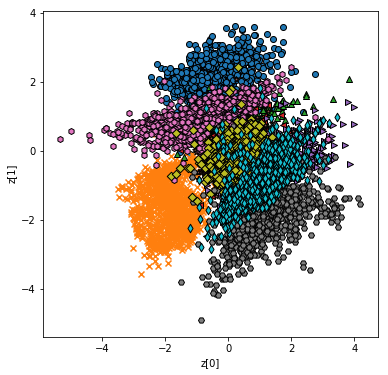

In [0]:
plot_latent_distribution(encoder,
                         x_test,
                         y_test,
                         batch_size=128)

The `plot_generated_images` function displays the images. The axes represent the particular latent distribution `z` used for each image

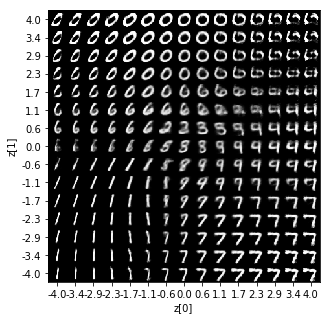

In [0]:
plot_generated_images(decoder)

#Generative Adversarial Networks
![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch6/gan.PNG?raw=true)

A GAN is a system of two components:
* **Generator**: This is the generative model itself. It takes a probability distribution (random noise) as input and tries to generate a realistic output image. Its purpose is similar to the decoder part of the VAE.
* **Discriminator**: This takes two alternating inputs: the real images of the training dataset or the generated fake samples from the generator. It tries to determine whether the input image comes from the real images or the generated ones.

The two networks are trained together as a system. On the one hand, the discriminator tries to get better at distinguishing between the real and fake images. On the other hand, the generator tries to output more realistic images, so it could "deceive" the discriminator into thinking that the generated image is real. The ultimate goal of the system is to make the generator so good that the discriminator wouldn't be able to distinguish between the real and fake images.

##Training GANs
The generator and the discriminator are trained separately and sequentially (one after the other), and alternate between the two phases multiple times.

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch6/gan_details.PNG?raw=true)

* The genearator is denoted with $G(z,\theta_g)$, where $\theta_g$ are the network weights, and $z$ is the latent vector, which serves as an input to the generator. $z$ is treated as a random seed value to kickstart the image-generation process, similar to the latent vector in the VAEs. $z$ has a probability distribution $p_z(z)$, which is usually random normal or random uniform. The generator outputs fake samples $x$ with a probability distribution of $p_g(x)$. This $p_g(x)$ is thought of as the probability distribution of the real data according to the generator.
* The discriminator is denoted with $D(x,\theta_d)$, where $\theta_d$ are the network weights. It takes as input either the real data with the $x\sim p_{data}(x)$ distribution, or the generated samples $x\sim p_g(x)$. The discriminator is a binary classifier, which outputs whether the input image is part of the real (network output 1) or the generated data (network output 0).
* During training, the discriminator and generator loss functions with $J^{(D)}$ and $J^{(G)}$, respectively.

GAN training is different compared to the training of a regular DNN, because there are two networks. This process can be thought of as a sequential minimax zero-sum game of two players (generator and discriminator):
* **Sequential**: Players take turns after one another. First, the discriminator tries to minimize $J^{(D)}$, but it can only do so by adjusting the weights $\theta_d$. Next, the generator tries to minimize $J^{(G)}$, but it can only adjust the weights $\theta_g$. This process is repeated multiple times.
* **Zero-sum**: The gains and losses of one player are exactly balanced by the gains or losses of the opposite player. That is, the sum of the generators's loss and the discriminator's loss is always 0:
$$J^{(G)}=-J^{(D)}$$
* **Minimax**: The strategy of the first player (generator) is to **minimize** the opponent's (discriminator) **maximum** score (hence the name). When the discriminator is trained, it becomes better at distinguishing between real and fake samples (minimizing $J^{(D)}$). Next, when the generator is trained, it tries to step up to the level of the newly-improved discriminator (minimizing $J^{(G)}$ is equivalent to maximizing $J^{(D)}$). The two networks are in constant competition. The cost function of the minimax game is denoted as $V$
$$\min_G\max_D V(G,D)$$
Assume both $J^{(G)}$ and $J^{(D)}$ will be at some local minimum after a number of training steps. Then, the solution to the minimax game is called the Nash equilibrium. A Nash equilibrium happens when one of the actors doesn't change its action, regardless of what the other actor may do. A Nash equilibrium in a GAN framework happens when the generator becomes so good that the discriminator is no longer able to distinguish between the generated and real samples. That is, the discriminator output will always be $\frac{1}{2}$ regardless of the presented input.

###Training the discriminator
The discriminator is a classification neural network and it can be trained in the usual way using graident descent and backpropagation. However, the training set is composed of equal parts real and generated samples. During the training process,
1. Depending on the input sample (real or fake), there are two paths:
  * Select the sample from the real data $x\sim p_{data}$, and use it to produce $D(x)$.
  * Generate fake samples $x\sim p_g$. Here, generator and discriminator work as a single network. Start with a random vector $z$, which is used to produce the generated sample $G(z)$. Then, it is used as input to the discriminator to produce the final output, $D(G(z))$.
2. Compute the loss function, which reflects the duality of the training data.
3. Backpropagate the error gradient and update the weights. the two
networks work together, the generator weights $\theta_g$ will be locked and only the discriminator weights $\theta_d$ will get update. This ensures the training process improves the discriminator performance by making it better, as opposed to making the generator worse.

Recall the formula for the cross-entropy loss:
$$H(p,q)=-\sum_{i=1}^{n}p_i(x)\log(q_i(x))$$
where $q_i(x)$ is the estimated probability of the output belonging to the $i$ class (out of $n$ total classes) and $p_i(x)$ is the actual probability. For simplicity, here the formula is only applied over a single training sample. In the case of binary classification, 
$$H(p,q)=-(p(x)\log q(x) + (1-p(x))\log(1-q(x)))$$
For a mini-batch of m samples,
$$H(p,q)=-\frac{1}{m}\sum_{j=1}^{m}(p(x_j)\log(q(x_j)) + (1-p(x_j))\log(1-q(x_j)))$$
Define the discriminator loss:
$$J^{(D)}=-\frac{1}{2}\mathbb{E}_{x\sim p_{data}}\log(D(x)) - \frac{1}{2}\mathbb{E}_z\log(1-D(G(z)))$$
This is just a cross-entropy loss for a binary classifier with some GAN-specific bells and whistles:
* The two components of the loss reflect the two possible classes (real or fake), which are in equal number in the training set.
* $\frac{1}{2}\mathbb{E}_{x\sim p_{data}}\log D(x)$ is the loss when the input is sampled from the real data. Ideally, in such cases, $D(x)=1$.
* $\mathbb{E}_{x\sim p_{data}}$ (expectation) implies that the $x$ is samples from $p_{data}$. This part of the loss means "when sampled from $p_{data}$, the discriminator output is expected to be $D(x)=1$". The $\frac{1}{2}$ is the cumulative class probability of the real data $p(x)$, since it comprises exactly half of the whole set.
* $\frac{1}{2}\mathbb{E}_z\log(1-D(G(z)))$ is the loss, when the input is sampled from the generated data. This term is maximized when $D(G(z))=0$.

To summarize, the discriminator loss will be zero when $D(x)=1$ for all $x\sim p_{data}$ and $D(x)=0$ for all generated $x\sim p_g$ (or $x=G(z)$).

###Training the generator
The generator is trained by making it better at deceiving the discriminator:
1. Start with a random latent vector $z$, and feed it through both the generator and discriminator to produce the output $D(G(z))$.
2. The loss function is the same as the discriminator loss. However, the goal here is to maximize it, rather than minimize it.
3. In the backward pass, the discriminator weights $\theta_d$ are locked and only the generator weights $\theta_g$ get adjusted. This forces to maximize the discriminator loss by making the generator better, instead of making the discriminator worse.

In this phase only the generated data are used. The part of the loss function that deals with real data will always be 0. Therefore, it can be simplified to
$$J^{(G)}=\mathbb{E}_z\log(1-D(G(z)))$$
The gradient of this formula is $-\frac{1}{1-D(G(z))}$ as shown below.

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch6/generator_grad.PNG?raw=true)

There is a limitation on the training. Early on, when the discriminator can easily distinguish between real and fake samples ($D(G(z))\approx 0$), the gradient will be close to zero. This would result in little learning of the weights $\theta_g$. (Known as diminished gradient). To solve this issue, use a different loss function:
$$J^{(G)}=-\mathbb{E}_z\log(D(G(z))$$
which is the dashed line shown above. This loss is still minimized when $D(G(z))\approx 1$ and at the same time the gradient is large when the generator underperforms. With this loss, the game is no longer zero-sum but this will not have a practical effect on the GAN framework. 

###Put it all together
Define the minimax objective in full:
$$\min_G\max_D V(G,D)=\frac{1}{2}\mathbb{E}_{x\sim p_{data}}\log(D(x))+\frac{1}{2}\mathbb{E}_z\log(1-D(G(z)))$$
The generator tries to minimize the objective, while the discriminator tries to maximize it. While the discriminator should minimize its loss, the minimax objective is a negative of the discriminator loss, and therefore the discriminator has to maximize it.

GAN training algorithm: \\
Repeat for a number of iterations:
1. Repeat for $k$ steps, where $k$ is a hyperparameter:
  * Sample a mini-batch of $m$ random samples from the latent space, $\{z^{(1)},z^{(2)},...,z^{(m)}\}\sim p_g(z)$.
  * Sample a mini-batch of $m$ samples from the real data, $\{x^{(1)},x^{(2)},...,x^{(m)}\}\sim p_{data}(x)$.
  * Update the discriminator weights $\theta_d$, by ascending the stochastic gradient of its loss:
  $$\nabla_{\theta_d}\frac{1}{m}\sum_{i=1}^{m}\left[\log(D(x^{(i)}))+\log(1-D(G(z^{(i)})))\right]$$
2. Sample a mini-batch of $m$ random samples from the latent space, $\{z^{(1)},z^{(2)},...,z^{(m)}\}\sim p_g(z)$.
3. Update the generator by descending the stochastic gradient of its loss:
$$\nabla_{\theta_g}\frac{1}{m}\sum_{i=1}^{m}\log(1-D(G(z^{(i)})))$$

#Types of GANs

##DCGAN
DCGAN stands for **Deep Convolutional Generative Adversarial networks**. In this new architecture, both the generator and the discriminator are convolutional networks. They have some constraints, which help to stabilize the training:
* The discriminator uses strided convolutions instead of pooling layers.
* The generator is a special type of CNN, which uses fractional-strided convolutions to increase the size of the images.
* Both networks use batch normalization.
* No fully-connected layers, with the exception of the last layer of the discriminator.
* LeaklyReLU activations for all layers of the generator, except the output, which uses tanh function.
* LeakyReLU activations for all layers of the discriminator, except the output, which uses signoid.

###The generator in DCGAN
The generator starts with a random latent vector $z$. To transform it into an image, use a network with a special type of convolution operation, called transposed convolution (also known as deconvolution or fractionally-strided convolution). The transposed convolution is an opposite of the regular convolution. Just like convolution, there are input, output, and a filter with weights, but here, the filter is applied over a single input neuron to produce multiple outputs. The following figure is an example of a simple 1D transposed convolution:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch6/transposed_convolution.PNG?raw=true)

By setting the stride larger than 1, the output size is increased, compared to the input. Let the size of the input slice be $I$, the size of the filter $F$, the stride $S$, and the input padding $P$. Then, the size $O$ of the output slice is given by
$$O=S(I-1)+F-2P$$

##Conditional GANs
Both the generator and discriminator receive some addtional conditioning input information $y$ in CGANs.

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch6/cgan.PNG?raw=true)

##GANs with MNIST
Keras

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.layers import BatchNormalization, Input, Dense, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


Implement the `build_generator` function. Use a simple fully-connected generator

In [0]:
def build_generator(latent_dim: int):
  '''
  Build discriminator network
  :param latent_dim: latent vector size
  '''

  model = Sequential([
                      Dense(128, input_dim=latent_dim),
                      LeakyReLU(alpha=0.2),
                      BatchNormalization(momentum=0.8),
                      Dense(256),
                      LeakyReLU(alpha=0.2),
                      BatchNormalization(momentum=0.8),
                      Dense(512),
                      LeakyReLU(alpha=0.2),
                      BatchNormalization(momentum=0.8),
                      Dense(np.prod((28,28,1)), activation='tanh'),
                      # reshape to MNIST image size
                      Reshape((28,28,1))
  ])

  model.summary()

  # the latent input vector z
  z = Input(shape=(latent_dim,))
  generated = model(z)

  # build model from the input and output
  return Model(z, generated)

Build the discriminator. A simple fully-connected network

In [0]:
def build_discriminator():
  '''
  Build discriminator network
  '''

  model = Sequential([
                      Flatten(input_shape=(28,28,1)),
                      Dense(256),
                      LeakyReLU(alpha=0.2),
                      Dense(128),
                      LeakyReLU(alpha=0.2),
                      Dense(1, activation='sigmoid')
  ], name='discriminator')

  model.summary()

  image = Input(shape=(28,28,1))
  output = model(image)

  return Model(image, output)

Implement the `train` function with the actual GAN training.

In [0]:
def train(generator, discriminator, combined, steps, batch_size):
  '''
  Train the GAN system
  :param generator: generator
  :param discriminator: discriminator
  :param combined:stacked generator and discrimiantor
  use the combined network when training the generator
  :param steps: number of alternating steps for training
  :param batch_size: size of the minibatch
  '''

  # Load the dataset
  (x_train, _), _ = mnist.load_data()

  # Rescale in [-1, 1] range
  x_train = (x_train.astype(np.float32) - 127.5) / 127.5
  x_train = np.expand_dims(x_train, axis=-1)

  # Discriminator ground truths
  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  latent_dim = generator.input_shape[1]

  for step in range(steps):
    # Training the discriminator
    # Select a random batch of images
    real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]

    # Random batch of noise
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate a batch of new images
    generated_images = generator.predict(noise)

    # Train the discriminator
    discriminator_real_loss = discriminator.train_on_batch(real_images, real)
    discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake)
    discriminator_loss = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)

    # Training the generator
    # random latent vector z
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Train the generator
    # Note that the "valid" labels is for the generalted images
    # because the goal is to maximize the discriminator loss
    generator_loss = combined.train_on_batch(noise, real)

    # Display progress
    print('%d [Discriminator loss: %.4f%%, acc.: %.2f%%] [Generator loss: %.4f%%]' %
          (step, discriminator_loss[0], 100 * discriminator_loss[1], generator_loss))

Implement a boilerplate function, `plot_generated_images`, to display some generated images after the training is finished:
1. Create an `nxn` grid (the `figure` viriable)
2. Create `nxn` random latent vectors (the `noise` variable), one for each generated image.
3. Generate the images and place them in the grid cells.
4. Display the result.

In [0]:
def plot_generated_images(generator):
  '''
  Display a nxn 2D manifold of digits
  :param generator: the generator
  '''

  n = 10
  digit_size = 28

  # big array containing all images
  figure = np.zeros((digit_size * n, digit_size * n))

  latent_dim = generator.input_shape[1]

  # n*n random latent distributions
  noise = np.random.normal(0, 1, (n*n, latent_dim))

  # generate the images
  generated_images = generator.predict(noise)

  # fill the big array with images
  for i in range(n):
    for j in range(n):
      slice_i = slice(i * digit_size, (i+1) * digit_size)
      slice_j = slice(j * digit_size, (j+1) * digit_size)
      figure[slice_i, slice_j] = np.reshape(generated_images[i * n + j], (28,28))

  # plot the results
  plt.figure(figsize=(6,5))
  plt.axis('off')
  plt.imshow(figure, cmap='Greys_r')
  plt.show() 

Build the generator, discriminator, and the combined network. Run the training for 15,000 steps using the Adam optimizer, and plot the results once it's done:

In [0]:
latent_dim = 64

In [0]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(lr=0.0002, beta_1=0.5),
                      metrics=['accuracy'])




Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 233,985
Trainable params: 233,985
Non-trainable params: 0
____________________________________________

In [0]:
# Build the generator
generator = build_generator(latent_dim)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 512)             

In [0]:
# Generator input z
z = Input(shape=(latent_dim,))
generated_images = generator(z)

In [0]:
# Only train the generator for the combined model
discriminator.trainable = False

In [0]:
# The discriminator takes generated image as input and determines validity
real_or_fake = discriminator(generated_images)

In [0]:
# Stack the generator and discriminator in a combined model
# Train the generator to deceive the discriminator
combined = Model(z, real_or_fake)
combined.compile(loss='binary_crossentropy',
                 optimizer=Adam(lr=0.0002, beta_1=0.5))

In [0]:
# Train the GAN system
train(generator=generator,
      discriminator=discriminator,
      combined=combined,
      steps=15000,
      batch_size=128)

11493376/11490434 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [Discriminator loss: 1.1583%, acc.: 42.97%] [Generator loss: 0.9051%]
1 [Discriminator loss: 0.6469%, acc.: 58.20%] [Generator loss: 0.8883%]
2 [Discriminator loss: 0.4428%, acc.: 84.38%] [Generator loss: 0.8870%]
3 [Discriminator loss: 0.3859%, acc.: 82.42%] [Generator loss: 0.8968%]
4 [Discriminator loss: 0.3469%, acc.: 86.33%] [Generator loss: 0.8747%]
5 [Discriminator loss: 0.3264%, acc.: 85.55%] [Generator loss: 0.8846%]
6 [Discriminator loss: 0.3119%, acc.: 87.11%] [Generator loss: 0.9200%]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7 [Discriminator loss: 0.3062%, acc.: 89.06%] [Generator loss: 0.9515%]
8 [Discriminator loss: 0.2809%, acc.: 91.41%] [Generator loss: 0.9376%]
9 [Discriminator loss: 0.2890%, acc.: 89.45%] [Generator loss: 0.9478%]
10 [Discriminator loss: 0.2814%, acc.: 91.02%] [Generator loss: 0.9833%]
11 [Discriminator loss: 0.2828%, acc.: 90.23%] [Generator loss: 1.0025%]
12 [Discriminator loss: 0.2504%, acc.: 96.48%] [Generator loss: 1.0362%]
13 [Discriminator loss: 0.2498%, acc.: 94.14%] [Generator loss: 1.0971%]
14 [Discriminator loss: 0.2660%, acc.: 93.75%] [Generator loss: 1.0881%]
15 [Discriminator loss: 0.2491%, acc.: 94.92%] [Generator loss: 1.1120%]
16 [Discriminator loss: 0.2261%, acc.: 95.70%] [Generator loss: 1.1172%]
17 [Discriminator loss: 0.2128%, acc.: 98.05%] [Generator loss: 1.1508%]
18 [Discriminator loss: 0.2241%, acc.: 96.88%] [Generator loss: 1.1986%]
19 [Discriminator loss: 0.2171%, acc.: 98.05%] [Generator loss: 1.2015%]
20 [Discriminator loss: 0.2086%, acc.: 97.66%] [Genera

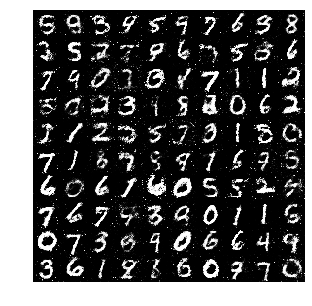

In [0]:
# Display some random generated images
plot_generated_images(generator)